In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from models.loss import SinkhornDistance
from pytorch_metric_learning import losses


In [30]:
import os 
import glob
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import torch
from glob import glob
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

class TimeSeriesDataset(Dataset):
    def __init__(self, folder_nolayoff, folder_layoff, src_col):
        
        # csvs_layoffs = glob.glob(folder_layoff + "/*.csv")
        # csvs_nolayoffs = glob.glob(folder_nolayoff + "/*.csv")
        X_train = []
        Y_train = []
        all_csv_files = []
        EXT = "*.csv"  # Define the variable EXT
        for path, subdir, files in os.walk(folder_layoff):
            
            for file in glob(os.path.join(path, EXT)):
                # print(file)
                df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
                ## If length of dataset is over 90, then cut it to 90
                if len(df) > 90:
                    print("OVER LENGTH", file)
                    df = df[-90:]
                ## If length of dataset is less than 90, then skip it
                if len(df) < 90:
                    continue
                X_train.append(df[src_col].values)
                Y_train.append(1)
                # all_csv_files.append(file)

        for path, subdir, files in os.walk(folder_nolayoff):
            for file in glob(os.path.join(path, EXT)):
                df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
                ## If length of dataset is over 90, then cut it to 90
                if len(df) > 90:
                    print("OVER LENGTH", file)
                    df = df[-90:]

                ## If length of dataset is less than 90, then skip it
                if len(df) < 90:
                    continue
                X_train.append(df[src_col].values)
                Y_train.append(0)
                # all_csv_files.append(file)

            
        X_train = torch.from_numpy(np.array(X_train))
        Y_train = torch.from_numpy(np.array(Y_train))

        if len(X_train.shape) < 3:
            X_train = X_train.unsqueeze(2)

        if X_train.shape.index(min(X_train.shape[1], X_train.shape[2])) != 1:  # make sure the Channels in second dim
            X_train = X_train.permute(0, 2, 1)

        self.X_train = X_train
        self.Y_train = Y_train
        self.num_channels = X_train.shape[1]
        self.len = X_train.shape[0]

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.X_train[idx].float(), self.Y_train[idx]



In [32]:
src_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_train", "datasets\\stocks_layoffs_train", "open_percent_change")
trg_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs_train", "datasets\\chronos_stocks_layoffs_train", "median_percent_change")

In [33]:
src_loader = DataLoader(dataset=src_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)
trg_loader = DataLoader(dataset=trg_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)

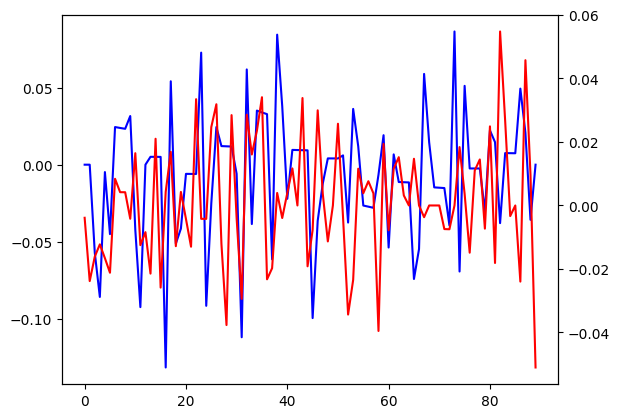

In [35]:
src_x = src_loader.dataset[0][0][0]
trg_x = trg_loader.dataset[0][0][0]
fig, ax1 = plt.subplots()
ax1.plot(src_x, label="src: Stock Prices", color="blue")
ax2  = ax1.twinx()
ax2.plot(trg_x, label="trg: Total Layoffs", color="red")

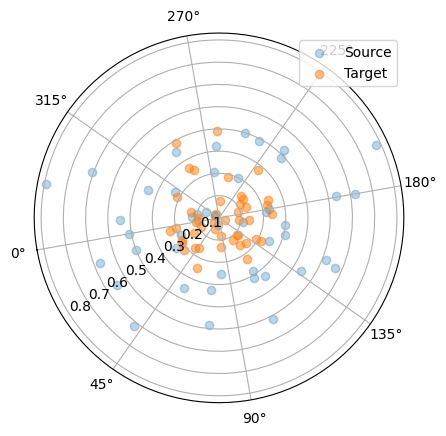

In [36]:
src_x = torch.tensor(src_x)
trg_x = torch.tensor(trg_x)

# Extract frequency features for the source domain
x_ft_src = torch.fft.rfft(src_x)
r_src = x_ft_src.abs()
p_src = x_ft_src.angle() 
# Extract frequency features for the target domain
x_ft_trg = torch.fft.rfft(trg_x)
r_trg = x_ft_trg.abs()
p_trg = x_ft_trg.angle() 

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(p_src, r_src, alpha=0.3, label='Source')
c = ax.scatter(p_trg, r_trg, alpha=0.5, label='Target')


ax.set_theta_zero_location('W', offset=10)
ax.legend(loc='best')

In [37]:
class classifier(nn.Module):
    def __init__(self, configs):
        super(classifier, self).__init__()
        model_output_dim = configs.out_dim 
        self.logits = nn.Linear(model_output_dim, configs.num_classes, bias=False)
        self.tmp= 0.1

    def forward(self, x):
        predictions = self.logits(x)/self.tmp
        return predictions

In [38]:
# Frequency Feature Extractor
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, fl=128):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        
    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x = torch.cos(x)
        # print(x.shape)
        x_ft = torch.fft.rfft(x,norm='ortho')
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        # print(x_ft.shape)
        # print(x_ft[:, :, :self.modes1].shape)
        # print(self.weights1.shape)
        # print(out_ft)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1) 
        r = out_ft[:, :, :self.modes1].abs()
        p = out_ft[:, :, :self.modes1].angle() 
        return torch.concat([r,p],-1), out_ft

In [39]:
# Time Feature Extractor
class CNN(nn.Module):
    def __init__(self, configs):
        super(CNN, self).__init__()
        self.width = configs.input_channels
        self.channel = configs.input_channels
        self.fl =   configs.sequence_len
        self.fc0 = nn.Linear(self.channel, self.width) # input channel is 2: (a(x), x)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(configs.input_channels, configs.mid_channels, kernel_size=configs.kernel_size,
                      stride=configs.stride, bias=False, padding=(configs.kernel_size // 2)),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(configs.dropout)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(configs.mid_channels, configs.mid_channels , kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(configs.mid_channels , configs.final_out_channels, kernel_size=8, stride=1, bias=False,
                      padding=4),
            nn.BatchNorm1d(configs.final_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(configs.features_len)

        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block3(x)
        x = self.adaptive_pool(x)
        x_flat = x.reshape(x.shape[0], -1)
        return x_flat

In [40]:
class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain adaptation algorithm.
    Subclasses should implement the update() method.
    """

    def __init__(self, configs):
        super(Algorithm, self).__init__()
        self.configs = configs
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def update(self, *args, **kwargs):
        raise NotImplementedError


In [41]:
class tf_encoder(nn.Module):
    def __init__(self, configs):
        super(tf_encoder, self).__init__()
        self.modes1 = configs.fourier_modes   # Number of low-frequency modes to keep
        self.width = configs.input_channels
        self.length =  configs.sequence_len
        self.freq_feature = SpectralConv1d(self.width, self.width, self.modes1,self.length)  # Frequency Feature Encoder
        self.bn_freq = nn.BatchNorm1d(configs.fourier_modes*2)   # It doubles because frequency features contain both amplitude and phase
        self.cnn = CNN(configs).to('cuda')  # Time Feature Encoder
        self.avg = nn.Conv1d(self.width, 1, kernel_size=3 ,
                  stride=configs.stride, bias=False, padding=(3 // 2))   


    def forward(self, x):
        ef, out_ft = self.freq_feature(x)
        ef = F.relu(self.bn_freq(self.avg(ef).squeeze()))
        et = self.cnn(x)
        f = torch.concat([ef,et],-1)
        return F.normalize(f), out_ft

class tf_decoder(nn.Module):
    def __init__(self, configs):
        super(tf_decoder, self).__init__()
        self.input_channels, self.sequence_len = configs.input_channels, configs.sequence_len
        self.bn1 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.bn2 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.convT = torch.nn.ConvTranspose1d(configs.final_out_channels, self.sequence_len, self.input_channels, stride=1)
        self.modes = configs.fourier_modes

    def forward(self, f, out_ft):
        x_low = self.bn1(torch.fft.irfft(out_ft, n=self.sequence_len))   # reconstruct  time series by using low frequency frequency features
        et = f[:,self.modes*2:]
        x_high = F.relu(self.bn2(self.convT(et.unsqueeze(2)).permute(0,2,1))) # reconstruct time series by using time features for high frequency patterns. 
        return x_low + x_high

In [42]:
class RAINCOAT(Algorithm):
    def __init__(self, configs, hparams, device):
        super(RAINCOAT, self).__init__(configs)
        self.feature_extractor = tf_encoder(configs).to(device)
        self.decoder = tf_decoder(configs).to(device)
        self.classifier = classifier(configs).to(device)
        
        self.optimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters()) + \
                list(self.decoder.parameters())+\
                list(self.classifier.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
        self.coptimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters())+list(self.decoder.parameters()),
            lr=1*hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
            
        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.loss_func = losses.ContrastiveLoss(pos_margin=0.5)
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')
        
    def update(self, src_x, src_y, trg_x):
  
        self.optimizer.zero_grad()
        # Encode both source and target features via our time-frequency feature encoder
        src_feat, out_s = self.feature_extractor(src_x)   
        trg_feat, out_t = self.feature_extractor(trg_x)
        # Decode extracted features to time series
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        # Compute reconstruction loss 
        recons = 1e-4 * (self.recons(src_recon, src_x) + self.recons(trg_recon, trg_x))
        recons.backward(retain_graph=True)
        # Compute alignment loss
        dr, _, _ = self.sink(src_feat, trg_feat)
        sink_loss = dr
        sink_loss.backward(retain_graph=True)
        # Compute classification loss
        src_pred = self.classifier(src_feat)
        loss_cls = self.cross_entropy(src_pred, src_y) 
        loss_cls.backward(retain_graph=True)
        self.optimizer.step()
        return {'Src_cls_loss': loss_cls.item(),'Sink': sink_loss.item()}
    
    def correct(self,src_x, src_y, trg_x):
        self.coptimizer.zero_grad()
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        recons = 1e-4 * (self.recons(trg_recon, trg_x) + self.recons(src_recon, src_x))
        recons.backward()
        self.coptimizer.step()
        return {'recon': recons.item()}

In [43]:
def eval(algorithm, loader, final=False):
    device = 'cuda'
    feature_extractor = algorithm.feature_extractor.to(device)
    classifier = algorithm.classifier.to(device)
    if final == True:
        feature_extractor.load_state_dict(torch.load('backbone.pth'))
        classifier.load_state_dict(torch.load('classifier.pth'))
    feature_extractor.eval()
    classifier.eval()
    trg_pred_labels = np.array([])
    trg_true_labels = np.array([])
    with torch.no_grad():
        for data, labels in loader:
            data = data.float().to(device)
            labels = labels.view((-1)).long().to(device)
            features,_ = feature_extractor(data)
            predictions = classifier(features)

            pred = predictions.detach().argmax(dim=1)  # get the index of the max log-probability

            trg_pred_labels = np.append(trg_pred_labels, pred.cpu().numpy())
            trg_true_labels = np.append(trg_true_labels, labels.data.cpu().numpy())
    accuracy = accuracy_score(trg_true_labels, trg_pred_labels)
    f1 = f1_score(trg_pred_labels, trg_true_labels, pos_label=None, average="macro")
    return accuracy *100, f1

In [44]:
class data_config():
    def __init__(self):
        # super(WISDM_config, self)
        # self.class_names = ['walk', 'jog', 'sit', 'stand', 'upstairs', 'downstairs']
        self.sequence_len = 90
        # Transfer scenarios, e.g., from source domain 2 to target domain 32
        # self.scenarios = [("2", "32"), ("4", "15"),("7", "30"),('12','7'), ('12','19'),('18','20'),\
                        #   ('20','30'), ("21", "31"),("25", "29"), ('26','2')]

        # self.num_classes = 6
        self.shuffle = True
        self.drop_last = False
        self.normalize = True

        # model configs
        self.input_channels = 1
        self.kernel_size = 5
        self.stride = 1
        self.dropout = 0.5
        self.num_classes = 2
        self.width = 32  
        # for Fourier Frequency Feature Extration, number of modes to keep 
        self.fourier_modes = 32
        # features
        self.mid_channels = 32
        self.final_out_channels = 90
        self.out_dim = self.final_out_channels+ self.fourier_modes * 2
        self.features_len = 1

<h4> Training </h4>

In [12]:
dataset_configs = data_config()
hparams = {"batch_size":2, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 100}

src_train_data = TimeSeriesDataset("datasets\\stocks_no_layoffs\\Retail_train", "datasets\\stocks_layoffs\\Retail_train", "open_percent_change")
src_test_data = TimeSeriesDataset("datasets\\stocks_no_layoffs\\Retail_test", "datasets\\stocks_layoffs\\Retail_test", "open_percent_change")
trg_train_data = TimeSeriesDataset("datasets\\stocks_no_layoffs\\Transportation_train", "datasets\\stocks_layoffs\\Transportation_train", "open_percent_change")
trg_test_data = TimeSeriesDataset("datasets\\stocks_no_layoffs\\Transportation_test", "datasets\\stocks_layoffs\\Transportation_test", "open_percent_change")

src_train_dl = DataLoader(dataset=src_train_data, batch_size=2, 
                            shuffle=True, drop_last=True, num_workers=0)
src_test_dl = DataLoader(dataset=src_test_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)

trg_train_dl = DataLoader(dataset=trg_train_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)
trg_test_dl = DataLoader(dataset=trg_test_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)

device = 'cuda'
algorithm = RAINCOAT(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        # print(src_x)
        loss = algorithm.update(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

### Correction 
for i in range(10):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        loss = algorithm.correct(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')
tar_acc, tar_f1 = eval(algorithm, trg_train_dl,final=True)
print(f'Target Accuracy after correction:{tar_acc}, Target F1:{tar_f1}')

C:\Users\msuehle\AppData\Local\Temp\ipykernel_11356\3210516069.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
C:\Users\msuehle\AppData\Local\Temp\ipykernel_11356\3210516069.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
C:\Users\msuehle\AppData\Local\Temp\ipykernel_11356\3210516069.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
C:\Users\msuehle\AppData\Local\

KeyboardInterrupt: 

In [17]:
dataset_configs = data_config()
hparams = {"batch_size":2, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 100}

src_train_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs\\Retail_train", "datasets\\chronos_stocks_layoffs\\Retail_train", "median_percent_change")
src_test_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs\\Retail_test", "datasets\\chronos_stocks_layoffs\\Retail_test", "median_percent_change")
trg_train_data = TimeSeriesDataset("datasets\\stocks_no_layoffs\\Retail_train", "datasets\\stocks_layoffs\\Retail_train", "open_percent_change")
trg_test_data = TimeSeriesDataset("datasets\\stocks_no_layoffs\\Retail_test", "datasets\\stocks_layoffs\\Retail_test", "open_percent_change")

src_train_dl = DataLoader(dataset=src_train_data, batch_size=2, 
                            shuffle=True, drop_last=True, num_workers=0)
src_test_dl = DataLoader(dataset=src_test_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)

trg_train_dl = DataLoader(dataset=trg_train_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)
trg_test_dl = DataLoader(dataset=trg_test_data, batch_size=2, 
                                shuffle=True, drop_last=True, num_workers=0)

device = 'cuda'
algorithm = RAINCOAT(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        # print(src_x)
        loss = algorithm.update(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

### Correction 
for i in range(10):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        loss = algorithm.correct(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')
tar_acc, tar_f1 = eval(algorithm, trg_train_dl,final=True)
print(f'Target Accuracy after correction:{tar_acc}, Target F1:{tar_f1}')

C:\Users\msuehle\AppData\Local\Temp\ipykernel_6636\3210516069.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
C:\Users\msuehle\AppData\Local\Temp\ipykernel_6636\3210516069.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
C:\Users\msuehle\AppData\Local\Temp\ipykernel_6636\3210516069.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True).sort_index()
C:\Users\msuehle\AppData\Local\Tem

Epoch 0: Validation Accuracy on Source Test is 50.0
Epoch 10: Validation Accuracy on Source Test is 63.888888888888886
Epoch 20: Validation Accuracy on Source Test is 75.0
Epoch 30: Validation Accuracy on Source Test is 69.44444444444444
Epoch 40: Validation Accuracy on Source Test is 83.33333333333334
Epoch 50: Validation Accuracy on Source Test is 75.0
Epoch 60: Validation Accuracy on Source Test is 80.55555555555556
Epoch 70: Validation Accuracy on Source Test is 83.33333333333334
Epoch 80: Validation Accuracy on Source Test is 80.55555555555556
Epoch 90: Validation Accuracy on Source Test is 86.11111111111111
Target Accuracy before correction:40.0, Target F1:0.2857142857142857
Epoch 0: Validation Accuracy on Source Test is 80.55555555555556
Target Accuracy after correction:47.5, Target F1:0.4129979035639413


RAINCOAT training

In [45]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset_configs = data_config()
hparams = {"batch_size":2, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 50}

src_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs_train", "datasets\\chronos_stocks_layoffs_train", "median_percent_change")
trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_train", "datasets\\stocks_layoffs_train", "open_percent_change")

test_src_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs_test", "datasets\\chronos_stocks_layoffs_test", "median_percent_change")
test_trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_test", "datasets\\stocks_layoffs_test", "open_percent_change")

validation_split = .2
random_seed= 42
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(src_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
src_train_sampler = SubsetRandomSampler(train_indices)
src_valid_sampler = SubsetRandomSampler(val_indices)

src_train_dl = DataLoader(dataset=src_data, batch_size=2, 
                            sampler=src_train_sampler, drop_last=True, num_workers=0)

src_valid_dl = DataLoader(dataset=src_data, batch_size=2, 
                            sampler=src_valid_sampler, drop_last=True, num_workers=0)

src_test_dl = DataLoader(dataset=test_src_data, batch_size=2, 
                         drop_last=True, num_workers=0)

# Creating data indices for training and validation splits:
dataset_size = len(trg_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
trg_train_sampler = SubsetRandomSampler(train_indices)
trg_valid_sampler = SubsetRandomSampler(val_indices)

trg_train_dl = DataLoader(dataset=trg_data, batch_size=2, 
                                sampler=trg_train_sampler, drop_last=True, num_workers=0)

trg_valid_dl = DataLoader(dataset=trg_data, batch_size=2, 
                                sampler=trg_valid_sampler, drop_last=True, num_workers=0)

trg_test_dl = DataLoader(dataset=test_trg_data, batch_size=2,
                         drop_last=True, num_workers=0)

device = 'cuda'
algorithm = RAINCOAT(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        # print(src_x)
        loss = algorithm.update(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_valid_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

### Correction 
for i in range(10):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        loss = algorithm.correct(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')
tar_acc, tar_f1 = eval(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy after correction:{tar_acc}, Target F1:{tar_f1}')

Epoch 0: Validation Accuracy on Source Test is 46.34146341463415
Epoch 10: Validation Accuracy on Source Test is 56.09756097560976
Epoch 20: Validation Accuracy on Source Test is 52.4390243902439
Epoch 30: Validation Accuracy on Source Test is 56.09756097560976
Epoch 40: Validation Accuracy on Source Test is 46.34146341463415
Target Accuracy before correction:56.99999999999999, Target F1:0.46081504702194354
Epoch 0: Validation Accuracy on Source Test is 50.303030303030305
Target Accuracy after correction:56.99999999999999, Target F1:0.46081504702194354


just classifier on target

In [46]:
class plain_data_config():
    def __init__(self):
        # super(WISDM_config, self)
        # self.class_names = ['walk', 'jog', 'sit', 'stand', 'upstairs', 'downstairs']
        self.sequence_len = 90
        # Transfer scenarios, e.g., from source domain 2 to target domain 32
        # self.scenarios = [("2", "32"), ("4", "15"),("7", "30"),('12','7'), ('12','19'),('18','20'),\
                        #   ('20','30'), ("21", "31"),("25", "29"), ('26','2')]

        # self.num_classes = 6
        self.shuffle = True
        self.drop_last = False
        self.normalize = True

        # model configs
        self.input_channels = 1
        self.kernel_size = 5
        self.stride = 1
        self.dropout = 0.5
        self.num_classes = 2
        self.width = 32  
        # for Fourier Frequency Feature Extration, number of modes to keep 
        self.fourier_modes = 32
        # features
        self.mid_channels = 32
        self.final_out_channels = 90
        # self.out_dim = self.final_out_channels+ self.fourier_modes * 2
        self.out_dim = 90
        self.features_len = 1

In [47]:
class Plain_Classifier(Algorithm):
    def __init__(self, configs, hparams, device):
        super(Plain_Classifier, self).__init__(configs)
        self.classifier = classifier(configs).to(device)
        
        self.optimizer = torch.optim.Adam(
                list(self.classifier.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )

        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.loss_func = losses.ContrastiveLoss(pos_margin=0.5)
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')
        
    def update(self, src_x, src_y):
  
        self.optimizer.zero_grad()

        # Compute classification loss
        src_pred = self.classifier(src_x)
        # print(src_pred.squeeze())
        # print(src_y)
        loss_cls = self.cross_entropy(src_pred.squeeze(), src_y) 
        loss_cls.backward(retain_graph=True)
        self.optimizer.step()
        return {'Src_cls_loss': loss_cls.item()}
    

In [48]:
def eval_plain(algorithm, loader, final=False):
    device = 'cuda'
    # feature_extractor = algorithm.feature_extractor.to(device)
    classifier = algorithm.classifier.to(device)
    if final == True:
        # feature_extractor.load_state_dict(torch.load('backbone.pth'))
        classifier.load_state_dict(torch.load('plain_classifier.pth'))
    # feature_extractor.eval()
    classifier.eval()
    trg_pred_labels = np.array([])
    trg_true_labels = np.array([])
    with torch.no_grad():
        for data, labels in loader:
            data = data.float().to(device)
            labels = labels.view((-1)).long().to(device)
            # features,_ = feature_extractor(data)
            predictions = classifier(data)

            pred = predictions.squeeze().detach().argmax(dim=1)  # get the index of the max log-probability

            trg_pred_labels = np.append(trg_pred_labels, pred.cpu().numpy())
            trg_true_labels = np.append(trg_true_labels, labels.data.cpu().numpy())

    accuracy = accuracy_score(trg_true_labels, trg_pred_labels)
    f1 = f1_score(trg_pred_labels, trg_true_labels, pos_label=None, average="macro")
    return accuracy *100, f1

plain train on target, eval on target

In [49]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset_configs = plain_data_config()
hparams = {"batch_size":2, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 50}

trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_train", "datasets\\stocks_layoffs_train", "open_percent_change")
test_trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_test", "datasets\\stocks_layoffs_test", "open_percent_change")

validation_split = .2
random_seed= 42
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(trg_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
trg_train_sampler = SubsetRandomSampler(train_indices)
trg_valid_sampler = SubsetRandomSampler(val_indices)

trg_train_dl = DataLoader(dataset=trg_data, batch_size=2, 
                                sampler=trg_train_sampler, drop_last=True, num_workers=0)

trg_valid_dl = DataLoader(dataset=trg_data, batch_size=2, 
                                sampler=trg_valid_sampler, drop_last=True, num_workers=0)

trg_test_dl = DataLoader(dataset=trg_data, batch_size=2, 
                            drop_last=True, num_workers=0)

device = 'cuda'
algorithm = Plain_Classifier(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    # joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, (src_x, src_y) in enumerate(trg_train_dl):
        src_x, src_y = src_x.float().to(device), src_y.long().to(device)
        loss = algorithm.update(src_x, src_y)

    acc, f1 = eval_plain(algorithm, trg_valid_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.classifier.state_dict(), 'plain_classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval_plain(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

Epoch 0: Validation Accuracy on Source Test is 52.5
Epoch 10: Validation Accuracy on Source Test is 48.75
Epoch 20: Validation Accuracy on Source Test is 47.5
Epoch 30: Validation Accuracy on Source Test is 45.0
Epoch 40: Validation Accuracy on Source Test is 43.75
Target Accuracy before correction:65.51724137931035, Target F1:0.6550384774112107


plain train on src, eval on target

In [50]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset_configs = plain_data_config()
hparams = {"batch_size":2, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 50}

src_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs_train", "datasets\\chronos_stocks_layoffs_train", "median_percent_change")
test_trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_test", "datasets\\stocks_layoffs_test", "open_percent_change")

validation_split = .2
random_seed= 42
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(src_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
src_train_sampler = SubsetRandomSampler(train_indices)
src_valid_sampler = SubsetRandomSampler(val_indices)

src_train_dl = DataLoader(dataset=src_data, batch_size=2, 
                            sampler=src_train_sampler, drop_last=True, num_workers=0)

src_valid_dl = DataLoader(dataset=src_data, batch_size=2, 
                            sampler=src_valid_sampler, drop_last=True, num_workers=0)

trg_test_dl = DataLoader(dataset=test_trg_data, batch_size=2, 
                                drop_last=True, num_workers=0)

device = 'cuda'
algorithm = Plain_Classifier(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    # joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, (src_x, src_y) in enumerate(src_train_dl):
        src_x, src_y = src_x.float().to(device), src_y.long().to(device)
        loss = algorithm.update(src_x, src_y)

    acc, f1 = eval_plain(algorithm, src_valid_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.classifier.state_dict(), 'plain_classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval_plain(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

Epoch 0: Validation Accuracy on Source Test is 60.97560975609756
Epoch 10: Validation Accuracy on Source Test is 50.0
Epoch 20: Validation Accuracy on Source Test is 53.65853658536586
Epoch 30: Validation Accuracy on Source Test is 52.4390243902439
Epoch 40: Validation Accuracy on Source Test is 53.65853658536586
Target Accuracy before correction:59.0, Target F1:0.5879811074263892


plain train on src and target, eval on target

In [51]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset_configs = plain_data_config()
hparams = {"batch_size":2, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 50}

src_data = TimeSeriesDataset("datasets\\chronos_stocks_no_layoffs_train", "datasets\\chronos_stocks_layoffs_train", "median_percent_change")
trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_train", "datasets\\stocks_layoffs_train", "open_percent_change")
test_trg_data = TimeSeriesDataset("datasets\\stocks_no_layoffs_test", "datasets\\stocks_layoffs_test", "open_percent_change")

validation_split = .2
random_seed= 42
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(src_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
src_train_sampler = SubsetRandomSampler(train_indices)
src_valid_sampler = SubsetRandomSampler(val_indices)

src_train_dl = DataLoader(dataset=src_data, batch_size=2, 
                            sampler=src_train_sampler, drop_last=True, num_workers=0)

src_valid_dl = DataLoader(dataset=src_data, batch_size=2, 
                            sampler=src_valid_sampler, drop_last=True, num_workers=0)


# Creating data indices for training and validation splits:
dataset_size = len(trg_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
trg_train_sampler = SubsetRandomSampler(train_indices)
trg_valid_sampler = SubsetRandomSampler(val_indices)

trg_train_dl = DataLoader(dataset=trg_data, batch_size=2, 
                                sampler=trg_train_sampler, drop_last=True, num_workers=0)

trg_valid_dl = DataLoader(dataset=trg_data, batch_size=2, 
                                sampler=trg_valid_sampler, drop_last=True, num_workers=0)

trg_test_dl = DataLoader(dataset=test_trg_data, batch_size=2, 
                                drop_last=True, num_workers=0)

device = 'cuda'
algorithm = Plain_Classifier(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    # joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, (src_x, src_y) in enumerate(src_train_dl):
        src_x, src_y = src_x.float().to(device), src_y.long().to(device)
        loss = algorithm.update(src_x, src_y)

    for step, (src_x, src_y) in enumerate(trg_train_dl):
        src_x, src_y = src_x.float().to(device), src_y.long().to(device)
        loss = algorithm.update(src_x, src_y)

    acc1, f11 = eval_plain(algorithm, src_valid_dl)
    acc2, f12 = eval_plain(algorithm, trg_valid_dl)
    acc = (acc1 + acc2) / 2
    f1 = (f11 + f12) / 2
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.classifier.state_dict(), 'plain_classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval_plain(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

Epoch 0: Validation Accuracy on Source Test is 49.359756097560975
Epoch 10: Validation Accuracy on Source Test is 46.951219512195124
Epoch 20: Validation Accuracy on Source Test is 48.1859756097561
Epoch 30: Validation Accuracy on Source Test is 51.25
Epoch 40: Validation Accuracy on Source Test is 50.625
Target Accuracy before correction:51.0, Target F1:0.50995099509951
